## Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from xml.etree import ElementTree
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import Regularizer
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE

## DATA LOADING

In [3]:
ANNOTATIONS_PATH = '../M2/facemask_dataset/annotations'
IMAGES_PATH = '../M2/facemask_dataset/images'

See the number of images and their annotations:

In [4]:
images_files = os.listdir('../M2/facemask_dataset/images')
annotations_files = os.listdir('../M2/facemask_dataset/annotations')

In [5]:
len(annotations_files), len(images_files)

(853, 853)

The dataset contains 853 images along with their annotations.

Gather the informations about the images (sizes, labels, bounding boxes) from their annotation files.

In [6]:
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [],'file': [], 'width': [], 'height': []}

for annotation in glob.glob(ANNOTATIONS_PATH + '/*.xml'):
    tree = ElementTree.parse(annotation)

    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag:
                    width = int(round(float(attribute.text)))

                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))

        if 'object' in element.tag:
            for attribute in list(element):
                if 'name' in attribute.tag:
                    name = attribute.text
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height]
                    information['file'] += [annotation.split('/')[-1][: -4].split('\\')[-1]]

                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]

                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]
                        
                        if 'xmax'in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]

                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [7]:
annots_info_df = pd.DataFrame(information)
annots_info_df

,xmin,ymin,xmax,ymax,label,file,width,height
0,79,105,109,142,without_mask,maksssksksss0,512,366
1,185,100,226,144,with_mask,maksssksksss0,512,366
2,325,90,360,141,without_mask,maksssksksss0,512,366
3,321,34,354,69,with_mask,maksssksksss1,400,156
4,224,38,261,73,with_mask,maksssksksss1,400,156
...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267
4068,344,80,377,106,with_mask,maksssksksss98,400,267
4069,181,54,273,162,mask_weared_incorrect,maksssksksss99,400,267
4070,99,87,176,165,with_mask,maksssksksss99,400,267


The number of dataframe's row is beyond 853 (the number of images) because there are more than one label contained in a single image.

In [8]:
# Add image file and annotation file columns
annots_info_df['annotation_file'] = annots_info_df['file'] + '.xml'
annots_info_df['image_file'] = annots_info_df['file'] + '.png'
annots_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4069,181,54,273,162,mask_weared_incorrect,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png


Rename the label 'mask_weared_incorrect' to 'wrongly_worn_mask' to get these order when they're encoded:
- 0 = 'with_mask'
- 1 = 'without_mask'
- 2 = 'wrongly_worn_mask'

In [9]:
annots_info_df['label'] = annots_info_df['label'].apply(lambda x: x.replace('mask_weared_incorrect', 'wrongly_worn_mask'))

In [10]:
annots_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4069,181,54,273,162,wrongly_worn_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png


## EXPLORATORY DATA ANALYSIS (EDA)

See the labels and bounding boxes on a random image in the dataset.

In [11]:
# Convert BGR to RGB
def convert_to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [12]:
# Display image
def render_image(image):
    plt.figure(figsize = (12, 8))
    plt.imshow(image)
    plt.show()

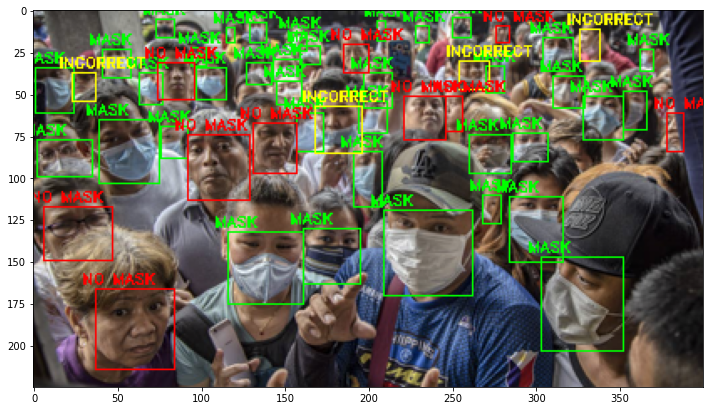

In [13]:
with_mask_list, incorrectly_worn_mask_list, no_mask_list = [], [], []

filter_image_file = annots_info_df['image_file'].isin(annots_info_df.image_file.sample())
random_image_df = pd.DataFrame(annots_info_df[filter_image_file])
RANDOM_IMAGE_PATH = '/M2/facemask_dataset/images/' + random_image_df['image_file'].unique().item()
random_image = cv2.imread(RANDOM_IMAGE_PATH)

random_image_rgb = convert_to_RGB(random_image)

for i in range(len(random_image_df)):
    bounding_box = [random_image_df['xmin'].iloc[i],
                    random_image_df['ymin'].iloc[i],
                    random_image_df['xmax'].iloc[i],
                    random_image_df['ymax'].iloc[i]]
    
    if random_image_df['label'].iloc[i] == 'with_mask':
        with_mask_list.append(bounding_box)

    elif random_image_df['label'].iloc[i] == 'wrongly_worn_mask':
        incorrectly_worn_mask_list.append(bounding_box)

    else:
        no_mask_list.append(bounding_box)

    bounding_boxes_dict = {'With Mask': with_mask_list,
                           'Incorrectly Worn': incorrectly_worn_mask_list,
                           'No Mask': no_mask_list}

for key, value in bounding_boxes_dict.items():
    for i in range(len(value)):
        color = (0, 255, 0) # Green
        text = 'MASK'
        if key == 'No Mask':
            color = (255, 0, 0) # Red
            text = 'NO MASK'
        elif key == 'Incorrectly Worn':
            color = (255, 255, 0) # Yellow
            text = 'INCORRECT'
        start_point = (value[i][0], value[i][1])
        end_point = (value[i][2], value[i][3])
        cv2.rectangle(random_image_rgb, start_point, end_point, color = color, thickness = 1)
        cv2.putText(random_image_rgb, org = (value[i][0] - 8, value[i][1] - 3), text = text, 
                    fontFace = cv2.FONT_HERSHEY_DUPLEX, fontScale = 0.3, color = color)

render_image(random_image_rgb)

See the distribution of the labels:

In [14]:
label_df = pd.DataFrame(annots_info_df['label'].value_counts(ascending= False))
label_df['Label'] = label_df.index
label_df_count = label_df.rename(columns= {'label':'Count'})

In [15]:
label_df_count

,Count,Label
with_mask,3232,with_mask
without_mask,717,without_mask
wrongly_worn_mask,123,wrongly_worn_mask


with_mask            3232
without_mask          717
wrongly_worn_mask     123
Name: label, dtype: int64

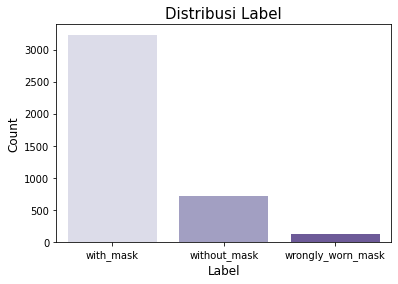

In [16]:
barplot = sns.barplot(data= label_df_count, x= 'Label', y= 'Count', palette=  'Purples')
plt.title('Distribusi Label', fontsize = 15)
plt.xlabel('Label', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
annots_info_df.label.value_counts()

The label distribution is imbalance, as the ratio of 'without_mask' and 'with_mask' label is 1 : 4,5 and the ratio of 'wrongly_worn_mask' and 'without_mask' is 1 : 5,8.

See the distribution of images' width and height.

In [17]:
annots_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4069,181,54,273,162,wrongly_worn_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png


In [18]:
df_width_height = annots_info_df[['width', 'height', 'annotation_file']].copy()

In [19]:
df_width_height

,width,height,annotation_file
0,512,366,maksssksksss0.xml
1,512,366,maksssksksss0.xml
2,512,366,maksssksksss0.xml
3,400,156,maksssksksss1.xml
4,400,156,maksssksksss1.xml
...,...,...,...
4067,400,267,maksssksksss98.xml
4068,400,267,maksssksksss98.xml
4069,400,267,maksssksksss99.xml
4070,400,267,maksssksksss99.xml


Delete the duplicated rows.

In [20]:
df_width_height_clean = df_width_height.drop_duplicates()

In [21]:
df_width_height_clean

,width,height,annotation_file
0,512,366,maksssksksss0.xml
3,400,156,maksssksksss1.xml
12,301,400,maksssksksss10.xml
13,400,226,maksssksksss100.xml
16,301,400,maksssksksss101.xml
...,...,...,...
4059,301,400,maksssksksss95.xml
4060,400,280,maksssksksss96.xml
4064,301,400,maksssksksss97.xml
4065,400,267,maksssksksss98.xml


In [22]:
df_width_height_ = df_width_height_clean.drop(['annotation_file'], axis= 1)

In [23]:
df_width_height_

,width,height
0,512,366
3,400,156
12,301,400
13,400,226
16,301,400
...,...,...
4059,301,400
4060,400,280
4064,301,400
4065,400,267


Skewness Value :  width    -0.128553
height    0.367124
dtype: float64


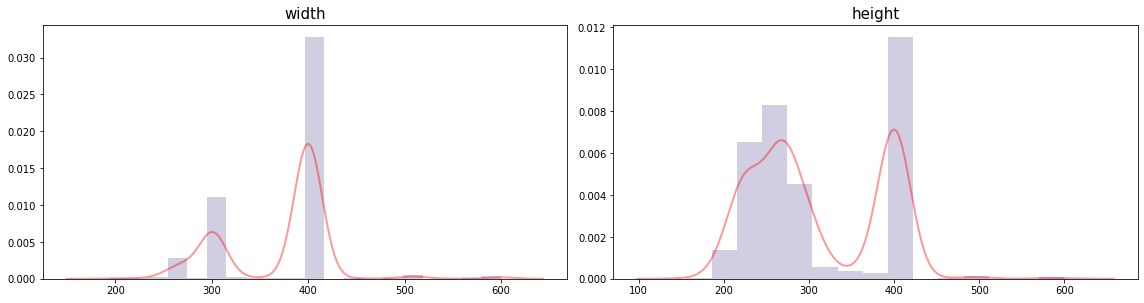

In [24]:
a = 2
b = 2
c = 1
plt.figure(figsize=(16, 8), facecolor='white')
print('Skewness Value : ', df_width_height_[df_width_height_.columns].skew())
for col in df_width_height_.columns:
    plt.subplot(a, b, c)
    sns.distplot(df_width_height_[col], kde_kws={'color':'r', 'lw':2, 'alpha': 0.4},hist_kws={'color':'#a29fc2', 'alpha': 0.5})
    plt.title(f"{col}", size=15)
    plt.xlabel('')
    plt.ylabel('')
    c = c+1
plt.tight_layout()

In [25]:
print('---Image Width---')
print(f'Min width: {min(df_width_height_.width)}')
print(f'Max width: {max(df_width_height_.width)}')
print(f'Mean width: {np.round(np.mean(df_width_height_.width))}')
print(f'Median width: {np.median(df_width_height_.width)}')
print('---Image Height---')
print(f'Min height: {min(df_width_height_.height)}')
print(f'Max height: {max(df_width_height_.height)}')
print(f'Mean height: {np.round(np.mean(df_width_height_.height))}')
print(f'Median height: {np.median(df_width_height_.height)}')

---Image Width---
Min width: 193
Max width: 600
Mean width: 371.0
Median width: 400.0
---Image Height---
Min height: 156
Max height: 600
Mean height: 309.0
Median height: 280.0


Most of the images has width size around 193 - 600 pixel, and height size around 156 - 600 pixel.

## DATA PREPROCESSING

Make a new image files contains the cropped images according to the bounding boxes. There are 4072 cropped image files.

In [26]:
annots_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4069,181,54,273,162,wrongly_worn_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png


Make directory for the cropped image files.

In [28]:
directory = 'cropped_images'
parent_directory = '/M2/facemask_dataset'
CROPPED_IMAGES_PATH = os.path.join(parent_directory, directory)
os.mkdir(CROPPED_IMAGES_PATH)

In [29]:
# Add a column for 'cropped_image_file'
annots_info_df['cropped_image_file'] = annots_info_df['file']
annots_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1
...,...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98
4069,181,54,273,162,wrongly_worn_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99


In [30]:
for i in range(len(annots_info_df)):
    IMAGE_PATH = IMAGES_PATH + '/' + annots_info_df['image_file'].iloc[i]
    image = cv2.imread(IMAGE_PATH)

    annots_info_df['cropped_image_file'].iloc[i] = annots_info_df['cropped_image_file'].iloc[i] + '_' + str(i) + '.png'
    cropped_image_filename = annots_info_df['cropped_image_file'].iloc[i]

    # Crop image according to it's bounding boxes
    xmin = annots_info_df['xmin'].iloc[i]
    ymin = annots_info_df['ymin'].iloc[i]
    xmax = annots_info_df['xmax'].iloc[i]
    ymax = annots_info_df['ymax'].iloc[i]

    cropped_image = image[ymin:ymax, xmin:xmax]

    CROPPED_IMAGE_PATH = os.path.join('/M2/facemask_dataset/cropped_images/', cropped_image_filename)
    cv2.imwrite(CROPPED_IMAGE_PATH, cropped_image)

See the number of cropped images:

In [31]:
cropped_images_files = os.listdir('../M2/facemask_dataset/cropped_images')
print('Jumlah cropped images: {}'.format(len(cropped_images_files)))

Jumlah cropped images: 4072


In [32]:
annots_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_0.png
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_1.png
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_2.png
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_3.png
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_4.png
...,...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98_4067.png
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98_4068.png
4069,181,54,273,162,wrongly_worn_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99_4069.png
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99_4070.png


### Train, Test, Val split

In [33]:
y = pd.DataFrame(annots_info_df['label'])
X = annots_info_df.drop(['label'], axis= 1)

**TEST SET**

Split 15 rows of the dataset for model inference, with the number of each labels:
- with_mask = 10
- without_mask = 3
- wrongly_worn_mask = 2

So the model can predict all of the 3 labels.

In [34]:
X_test = X.iloc[[0, 1, 2, 47, 3, 101, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
X_test

,xmin,ymin,xmax,ymax,file,width,height,annotation_file,image_file,cropped_image_file
0,79,105,109,142,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_0.png
1,185,100,226,144,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_1.png
2,325,90,360,141,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_2.png
47,23,114,77,172,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11_47.png
3,321,34,354,69,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_3.png
101,90,84,138,131,maksssksksss112,267,400,maksssksksss112.xml,maksssksksss112.png,maksssksksss112_101.png
4,224,38,261,73,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_4.png
5,299,58,315,81,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_5.png
6,143,74,174,115,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_6.png
7,74,69,95,99,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_7.png


In [35]:
y_test = y.iloc[[0, 1, 2, 47, 3, 101, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
y_test

,label
0,without_mask
1,with_mask
2,without_mask
47,wrongly_worn_mask
3,with_mask
101,wrongly_worn_mask
4,with_mask
5,with_mask
6,with_mask
7,with_mask


**TRAIN & VAL SET**

In [36]:
X_clean = X.drop([X.index[0], X.index[1], X.index[2], X.index[47], X.index[3], X.index[101], X.index[4], X.index[5],
                  X.index[6], X.index[7], X.index[8], X.index[9], X.index[10], X.index[11], X.index[11], X.index[12]])

In [37]:
X_clean

,xmin,ymin,xmax,ymax,file,width,height,annotation_file,image_file,cropped_image_file
13,189,30,245,88,maksssksksss100,400,226,maksssksksss100.xml,maksssksksss100.png,maksssksksss100_13.png
14,387,54,400,75,maksssksksss100,400,226,maksssksksss100.xml,maksssksksss100.png,maksssksksss100_14.png
15,118,87,163,126,maksssksksss100,400,226,maksssksksss100.xml,maksssksksss100.png,maksssksksss100_15.png
16,48,294,164,400,maksssksksss101,301,400,maksssksksss101.xml,maksssksksss101.png,maksssksksss101_16.png
17,212,57,251,106,maksssksksss102,400,225,maksssksksss102.xml,maksssksksss102.png,maksssksksss102_17.png
...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98_4067.png
4068,344,80,377,106,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98_4068.png
4069,181,54,273,162,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99_4069.png
4070,99,87,176,165,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99_4070.png


In [38]:
y_clean = y.drop([y.index[0], y.index[1], y.index[2], y.index[47], y.index[3], y.index[101], y.index[4], y.index[5],
                  y.index[6], y.index[7], y.index[8], y.index[9], y.index[10], y.index[11], y.index[11], y.index[12]])
y_clean

,label
13,with_mask
14,with_mask
15,with_mask
16,with_mask
17,with_mask
...,...
4067,with_mask
4068,with_mask
4069,wrongly_worn_mask
4070,with_mask


Split the dateset into Train set (80%) and Validation set (20%). Stratify the label, as it is imbalanced.

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_clean, y_clean, test_size= 0.2, stratify= y_clean, random_state= 42)

In [40]:
print('Jumlah baris & kolom X train: {}'.format(X_train.shape))
print('Jumlah baris & kolom X val: {}'.format(X_val.shape))

Jumlah baris & kolom X train: (3245, 10)
Jumlah baris & kolom X val: (812, 10)


See the label distribution in y train:

In [41]:
y_train

,label
1674,with_mask
1682,with_mask
2060,without_mask
2693,with_mask
1578,with_mask
...,...
3050,with_mask
2215,with_mask
2235,without_mask
120,with_mask


In [42]:
df_ytrain = pd.DataFrame(y_train.label.value_counts())
df_ytrain['Label'] = df_ytrain.index
df_ytrain_count = df_ytrain.rename(columns= {'label':'Count'})
df_ytrain_count

,Count,Label
with_mask,2577,with_mask
without_mask,571,without_mask
wrongly_worn_mask,97,wrongly_worn_mask


label            
with_mask            2577
without_mask          571
wrongly_worn_mask      97
dtype: int64

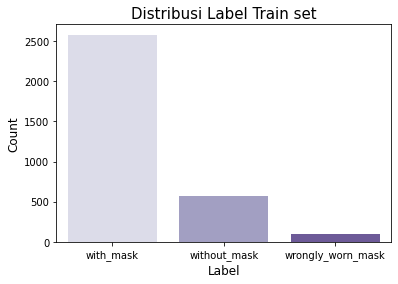

In [43]:
barplot_ytrain = sns.barplot(data= df_ytrain_count, x= 'Label', y= 'Count', palette=  'Purples')
plt.title('Distribusi Label Train set', fontsize = 15)
plt.xlabel('Label', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
y_train.value_counts()

In [44]:
X_train

,xmin,ymin,xmax,ymax,file,width,height,annotation_file,image_file,cropped_image_file
1674,36,73,95,141,maksssksksss42,400,353,maksssksksss42.xml,maksssksksss42.png,maksssksksss42_1674.png
1682,111,109,130,130,maksssksksss421,400,267,maksssksksss421.xml,maksssksksss421.png,maksssksksss421_1682.png
2060,166,53,179,67,maksssksksss498,400,272,maksssksksss498.xml,maksssksksss498.png,maksssksksss498_2060.png
2693,127,55,134,62,maksssksksss603,400,278,maksssksksss603.xml,maksssksksss603.png,maksssksksss603_2693.png
1578,106,70,129,98,maksssksksss399,400,267,maksssksksss399.xml,maksssksksss399.png,maksssksksss399_1578.png
...,...,...,...,...,...,...,...,...,...,...
3050,1,162,76,251,maksssksksss665,400,267,maksssksksss665.xml,maksssksksss665.png,maksssksksss665_3050.png
2215,384,65,392,75,maksssksksss518,400,225,maksssksksss518.xml,maksssksksss518.png,maksssksksss518_2215.png
2235,221,51,246,77,maksssksksss52,400,225,maksssksksss52.xml,maksssksksss52.png,maksssksksss52_2235.png
120,304,68,336,102,maksssksksss116,400,225,maksssksksss116.xml,maksssksksss116.png,maksssksksss116_120.png


### Pipeline

Build pipeline using Image Data Generator. Shuffle is set to 'False' as the data has been shuffled during splitting.

**TRAIN SET**

Make Train dataframe:

In [45]:
df_train = pd.concat([X_train, y_train], axis= 1)
df_train

,xmin,ymin,xmax,ymax,file,width,height,annotation_file,image_file,cropped_image_file,label
1674,36,73,95,141,maksssksksss42,400,353,maksssksksss42.xml,maksssksksss42.png,maksssksksss42_1674.png,with_mask
1682,111,109,130,130,maksssksksss421,400,267,maksssksksss421.xml,maksssksksss421.png,maksssksksss421_1682.png,with_mask
2060,166,53,179,67,maksssksksss498,400,272,maksssksksss498.xml,maksssksksss498.png,maksssksksss498_2060.png,without_mask
2693,127,55,134,62,maksssksksss603,400,278,maksssksksss603.xml,maksssksksss603.png,maksssksksss603_2693.png,with_mask
1578,106,70,129,98,maksssksksss399,400,267,maksssksksss399.xml,maksssksksss399.png,maksssksksss399_1578.png,with_mask
...,...,...,...,...,...,...,...,...,...,...,...
3050,1,162,76,251,maksssksksss665,400,267,maksssksksss665.xml,maksssksksss665.png,maksssksksss665_3050.png,with_mask
2215,384,65,392,75,maksssksksss518,400,225,maksssksksss518.xml,maksssksksss518.png,maksssksksss518_2215.png,with_mask
2235,221,51,246,77,maksssksksss52,400,225,maksssksksss52.xml,maksssksksss52.png,maksssksksss52_2235.png,without_mask
120,304,68,336,102,maksssksksss116,400,225,maksssksksss116.xml,maksssksksss116.png,maksssksksss116_120.png,with_mask


In [46]:
image_width = []
image_height = []
for i in range(len(df_train)):
    cropped_image_path = '/M2/facemask_dataset/cropped_images/' + df_train['cropped_image_file'].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    image_width.append(cropped_image.shape[0])
    image_height.append(cropped_image.shape[1])

In [47]:
image_target_size= (int(np.mean(image_width)), (int(np.mean(image_height))))
image_target_size

(34, 30)

Input images will be resized according to the average size of the cropped images.

In [49]:
# Pipeline Train set
train_image_generator = ImageDataGenerator(rescale= 1. / 255)

train_generator = train_image_generator.flow_from_dataframe(dataframe= df_train,
                                                          directory= CROPPED_IMAGES_PATH,
                                                          x_col= 'cropped_image_file',
                                                          y_col= 'label',
                                                          batch_size= 32,
                                                          seed= 42,
                                                          class_mode= 'categorical',
                                                          shuffle= False,
                                                          color_mode= 'rgb',
                                                          target_size= image_target_size)

Found 3245 validated image filenames belonging to 3 classes.


**VALIDATION SET**

Make Validation dataframe:

In [50]:
df_val = pd.concat([X_val, y_val], axis= 1)
df_val

,xmin,ymin,xmax,ymax,file,width,height,annotation_file,image_file,cropped_image_file,label
2690,154,17,161,23,maksssksksss603,400,278,maksssksksss603.xml,maksssksksss603.png,maksssksksss603_2690.png,with_mask
2349,55,10,65,20,maksssksksss539,400,267,maksssksksss539.xml,maksssksksss539.png,maksssksksss539_2349.png,with_mask
3394,110,11,117,19,maksssksksss723,400,226,maksssksksss723.xml,maksssksksss723.png,maksssksksss723_3394.png,without_mask
1421,79,48,97,69,maksssksksss363,400,197,maksssksksss363.xml,maksssksksss363.png,maksssksksss363_1421.png,with_mask
443,205,67,216,78,maksssksksss194,400,267,maksssksksss194.xml,maksssksksss194.png,maksssksksss194_443.png,without_mask
...,...,...,...,...,...,...,...,...,...,...,...
1072,213,101,238,130,maksssksksss296,400,226,maksssksksss296.xml,maksssksksss296.png,maksssksksss296_1072.png,with_mask
1267,88,87,107,106,maksssksksss331,400,267,maksssksksss331.xml,maksssksksss331.png,maksssksksss331_1267.png,wrongly_worn_mask
842,380,32,400,54,maksssksksss256,400,268,maksssksksss256.xml,maksssksksss256.png,maksssksksss256_842.png,with_mask
131,352,45,377,67,maksssksksss119,400,289,maksssksksss119.xml,maksssksksss119.png,maksssksksss119_131.png,without_mask


In [51]:
# Pipeline val set
val_image_generator = ImageDataGenerator(rescale= 1. / 255)

val_generator = val_image_generator.flow_from_dataframe(dataframe= df_val,
                                                        directory= CROPPED_IMAGES_PATH,
                                                        x_col= 'cropped_image_file',
                                                        y_col= 'label',
                                                        batch_size= 32,
                                                        seed= 42,
                                                        class_mode= 'categorical',
                                                        shuffle= False,
                                                        color_mode= 'rgb',
                                                        target_size= image_target_size)

Found 812 validated image filenames belonging to 3 classes.


**TEST SET**

Make Test dataframe:

In [52]:
df_test = pd.concat([X_test, y_test], axis= 1)
df_test

,xmin,ymin,xmax,ymax,file,width,height,annotation_file,image_file,cropped_image_file,label
0,79,105,109,142,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_0.png,without_mask
1,185,100,226,144,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_1.png,with_mask
2,325,90,360,141,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0_2.png,without_mask
47,23,114,77,172,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11_47.png,wrongly_worn_mask
3,321,34,354,69,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_3.png,with_mask
101,90,84,138,131,maksssksksss112,267,400,maksssksksss112.xml,maksssksksss112.png,maksssksksss112_101.png,wrongly_worn_mask
4,224,38,261,73,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_4.png,with_mask
5,299,58,315,81,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_5.png,with_mask
6,143,74,174,115,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_6.png,with_mask
7,74,69,95,99,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1_7.png,with_mask


In [53]:
# Pipeline Test set
test_image_generator = ImageDataGenerator(rescale= 1. / 255)

test_generator = test_image_generator.flow_from_dataframe(dataframe= df_test,
                                                          directory= CROPPED_IMAGES_PATH,
                                                          x_col= 'cropped_image_file',
                                                          y_col= 'label',
                                                          batch_size= 32,
                                                          seed= 42,
                                                          class_mode= 'categorical',
                                                          shuffle= False,
                                                          color_mode= 'rgb',
                                                          target_size= image_target_size)

Found 15 validated image filenames belonging to 3 classes.


## MODEL DEFINITION

In [54]:
input_shape = [int(np.mean(image_width)), int(np.mean(image_height)), 3]
input_shape

[34, 30, 3]

Make the base model with 3 convolution and pooling layers, 2 dense layers, and a dropout layer.

In [55]:
# Model Architecture
def model_01():
    input_layer = Input(shape= input_shape)
    conv_01 = Conv2D(32, 3, activation= 'relu')(input_layer)
    pool_01 = MaxPool2D(2)(conv_01)
    conv_02 = Conv2D(64, 3, activation= 'relu')(pool_01)
    pool_02 = MaxPool2D(2)(conv_02)
    conv_03 = Conv2D(128, 3, activation= 'relu')(pool_02)
    pool_03 = MaxPool2D(2)(conv_03)
    flatten_layer = Flatten()(pool_03)
    dense_01 = Dense(128, activation= 'relu')(flatten_layer)
    dropout_layer = Dropout(rate= 0.5)(dense_01)
    dense_02 = Dense(32, activation= 'relu')(dropout_layer)
    output_layer = Dense(3, activation= 'softmax')(dense_02)

    model = Model(inputs= input_layer,
                  outputs= output_layer)
    
    # Compile
    model.compile(optimizer= 'adam',
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy', metrics.Recall()])
    
    return model

In [57]:
model_01 = model_01()
print(model_01.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34, 30, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 4, 128)         73856 

## MODEL TRAINING

Train the model using early stopping and without early stopping (100 epochs).

In [58]:
# Fit Model_01 with Early Stopping
callbacks_01 = EarlyStopping()
history_01 = model_01.fit(train_generator, epochs= 100, validation_data= val_generator, callbacks= callbacks_01)

Epoch 1/100
102/102 [==============================] - 7s 41ms/step - loss: 0.4569 - accuracy: 0.8330 - recall: 0.7926 - val_loss: 0.2783 - val_accuracy: 0.9126 - val_recall: 0.9002
Epoch 2/100
102/102 [==============================] - 1s 11ms/step - loss: 0.2540 - accuracy: 0.9233 - recall: 0.9149 - val_loss: 0.2326 - val_accuracy: 0.9286 - val_recall: 0.9273


In [59]:
# Fit Model_01 without Early Stopping
history_02 = model_01.fit(train_generator, epochs= 100, validation_data= val_generator)

Epoch 1/100
102/102 [==============================] - 1s 12ms/step - loss: 0.2169 - accuracy: 0.9374 - recall: 0.9291 - val_loss: 0.2090 - val_accuracy: 0.9347 - val_recall: 0.9261
Epoch 2/100
102/102 [==============================] - 1s 10ms/step - loss: 0.1872 - accuracy: 0.9414 - recall: 0.9300 - val_loss: 0.2638 - val_accuracy: 0.9236 - val_recall: 0.9200
Epoch 3/100
102/102 [==============================] - 1s 10ms/step - loss: 0.1765 - accuracy: 0.9430 - recall: 0.9341 - val_loss: 0.2000 - val_accuracy: 0.9372 - val_recall: 0.9298
Epoch 4/100
102/102 [==============================] - 1s 11ms/step - loss: 0.1716 - accuracy: 0.9442 - recall: 0.9371 - val_loss: 0.2021 - val_accuracy: 0.9347 - val_recall: 0.9261
Epoch 5/100
102/102 [==============================] - 1s 11ms/step - loss: 0.1594 - accuracy: 0.9479 - recall: 0.9421 - val_loss: 0.1891 - val_accuracy: 0.9360 - val_recall: 0.9298
Epoch 6/100
102/102 [==============================] - 1s 11ms/step - loss: 0.1505 - accur

## MODEL EVALUATION

**MODEL 01**

With early stopping:

In [60]:
result_m1_1 = pd.DataFrame(history_01.history)
result_m1_1

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.456875,0.832974,0.792604,0.278315,0.912562,0.900246
1,0.253985,0.923267,0.914946,0.232624,0.928571,0.927340


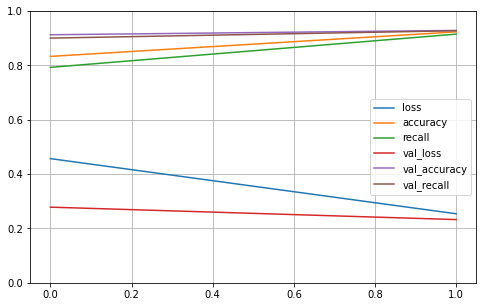

In [61]:
result_m1_1.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Without early stopping:

In [62]:
result_m1_2 = pd.DataFrame(history_02.history)
result_m1_2

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.216891,0.937442,0.929122,0.209001,0.934729,0.926108
1,0.187205,0.941448,0.930046,0.263781,0.923645,0.919951
2,0.176461,0.942989,0.934052,0.199968,0.937192,0.929803
3,0.171592,0.944222,0.937134,0.202059,0.934729,0.926108
4,0.159354,0.947920,0.942065,0.189111,0.935961,0.929803
...,...,...,...,...,...,...
95,0.004800,0.998151,0.998151,0.376520,0.945813,0.945813
96,0.013572,0.996302,0.995994,0.507559,0.938424,0.938424
97,0.004417,0.998459,0.998459,0.444269,0.950739,0.950739
98,0.002655,0.999384,0.999384,0.480117,0.947044,0.947044


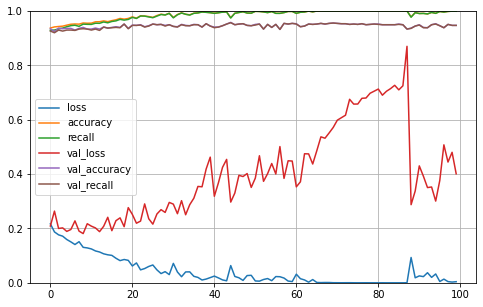

In [63]:
result_m1_2.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [64]:
def plot_line(df, ax, col, title, train_col, val_col):
    ax[col].plot(df[train_col])
    ax[col].plot(df[val_col])

    ax[col].set_title(title, fontweight= 'bold')
    ax[col].legend(['Train', 'Validation'])

def plot_result(result, train_recall, val_recall):
    fig, ax = plt.subplots(nrows= 1, ncols= 3, figsize= (16, 8))
    fig.suptitle('Model Performance', fontsize= 15, fontweight= 'bold')

    plot_line(result, ax, 0, 'Accuracy', 'accuracy', 'val_accuracy')
    plot_line(result, ax, 1, 'Recall', train_recall, val_recall)
    plot_line(result, ax, 2, 'Loss', 'loss', 'val_loss')
    plt.show()

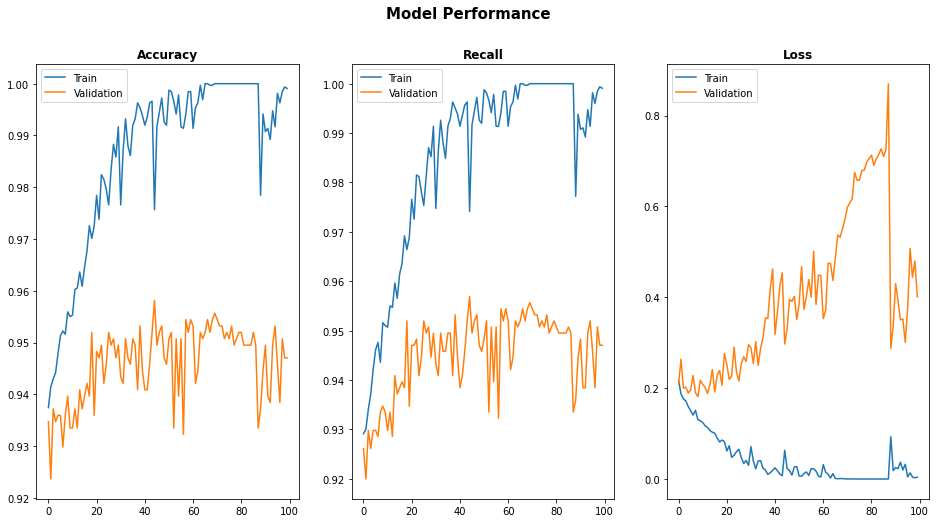

In [65]:
plot_result(result_m1_2, 'recall', 'val_recall')

The model overfit to the Train set, as the validation loss increased and train loss decreased along the epochs. Validation accuracy tends to stagnate.

### Evaluate Model_01 to the Test set

In [66]:
yhat_model_01 = model_01.predict_generator(test_generator)

In [67]:
predicted_classes_m1 = np.argmax(yhat_model_01, axis= 1)
predicted_classes_m1

array([1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [68]:
test_set_classes = test_generator.classes
test_set_classes

[1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [69]:
test_set_labels = list(test_generator.class_indices.keys())
test_set_labels

['with_mask', 'without_mask', 'wrongly_worn_mask']

In [70]:
print(classification_report(test_set_classes, predicted_classes_m1, target_names= test_set_labels))

                   precision    recall  f1-score   support

        with_mask       0.91      1.00      0.95        10
     without_mask       1.00      0.67      0.80         3
wrongly_worn_mask       1.00      1.00      1.00         2

         accuracy                           0.93        15
        macro avg       0.97      0.89      0.92        15
     weighted avg       0.94      0.93      0.93        15



In [71]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Purples):
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment= 'center',
                 color= 'white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [72]:
cm_m1 = confusion_matrix(test_set_classes, predicted_classes_m1)

Confusion Matrix, without normalization
[[10  0  0]
 [ 1  2  0]
 [ 0  0  2]]


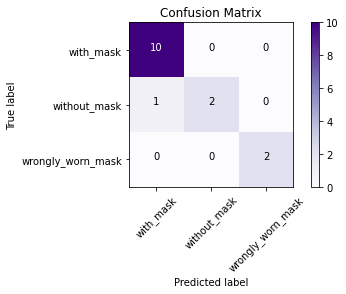

In [73]:
plot_confusion_matrix(cm_m1, test_set_labels, title= 'Confusion Matrix')

Model_01 can give a correct predictions of the label 'without_mask' and 'wrongly_worn_mask'. This fulfills the expectation that the model's Recall score should be high towards the people who do not wear masks, or wear it incorrectly.

On the other hand, the model can not be able to give a well prediction on the people who already wear masks.

## MODEL IMPROVEMENT

**MODEL 02**

- Adding more Dropout layers and increase it's dropout rate.
- Adding Random Normal weight initializer.
- Adding regularization to Convolution layers.

In [85]:
# Model Architecture
def model_02():
    input_layer = Input(shape= input_shape)
    conv_01 = Conv2D(32, 3, activation= 'relu', kernel_initializer= 'RandomNormal')(input_layer)
    pool_01 = MaxPool2D(2)(conv_01)
    conv_02 = Conv2D(64, 3, activation= 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.01))(pool_01)
    pool_02 = MaxPool2D(2)(conv_02)
    conv_03 = Conv2D(128, 3, activation= 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.01))(pool_02)
    pool_03 = MaxPool2D(2)(conv_03)
    flatten_layer = Flatten()(pool_03)
    dense_01 = Dense(256, activation= 'relu')(flatten_layer)
    dropout_01 = Dropout(rate= 0.8)(dense_01)
    dense_02 = Dense(64, activation= 'relu')(dropout_01)
    dropout_02 = Dropout(rate= 0.8)(dense_02)
    dense_03 = Dense(32, activation= 'relu')(dropout_02)
    output_layer = Dense(3, activation= 'softmax')(dense_03)

    model = Model(inputs= input_layer,
                  outputs= output_layer)
    
    # Compile
    model.compile(optimizer= 'adam',
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy', metrics.Recall()])
    
    return model

In [86]:
model_02 = model_02()

In [87]:
# Fit Model_02 without Early Stopping

history_03 = model_02.fit(train_generator, epochs= 100, validation_data= val_generator)

Epoch 1/100
102/102 [==============================] - 2s 14ms/step - loss: 1.0331 - accuracy: 0.7784 - recall_2: 0.7097 - val_loss: 0.6168 - val_accuracy: 0.7943 - val_recall_2: 0.7204
Epoch 2/100
102/102 [==============================] - 1s 12ms/step - loss: 0.5234 - accuracy: 0.7966 - recall_2: 0.7649 - val_loss: 0.4165 - val_accuracy: 0.8559 - val_recall_2: 0.7759
Epoch 3/100
102/102 [==============================] - 1s 11ms/step - loss: 0.3935 - accuracy: 0.9045 - recall_2: 0.7781 - val_loss: 0.3381 - val_accuracy: 0.9187 - val_recall_2: 0.9064
Epoch 4/100
102/102 [==============================] - 1s 11ms/step - loss: 0.3271 - accuracy: 0.9260 - recall_2: 0.8995 - val_loss: 0.2712 - val_accuracy: 0.9261 - val_recall_2: 0.9200
Epoch 5/100
102/102 [==============================] - 1s 10ms/step - loss: 0.2907 - accuracy: 0.9304 - recall_2: 0.9233 - val_loss: 0.2938 - val_accuracy: 0.9138 - val_recall_2: 0.9052
Epoch 6/100
102/102 [==============================] - 1s 11ms/step - 

In [88]:
result_m2 = pd.DataFrame(history_03.history)
result_m2

,loss,accuracy,recall_2,val_loss,val_accuracy,val_recall_2
0,1.033062,0.778428,0.709707,0.616771,0.794335,0.720443
1,0.523351,0.796610,0.764869,0.416487,0.855911,0.775862
2,0.393500,0.904468,0.778120,0.338089,0.918719,0.906404
3,0.327110,0.926040,0.899538,0.271202,0.926108,0.919951
4,0.290744,0.930354,0.923267,0.293777,0.913793,0.905172
...,...,...,...,...,...,...
95,0.161464,0.953467,0.948536,0.214866,0.931035,0.924877
96,0.165232,0.949769,0.944838,0.215206,0.940887,0.934729
97,0.161018,0.951926,0.948536,0.221905,0.928571,0.924877
98,0.148996,0.952542,0.949153,0.260670,0.923645,0.916256


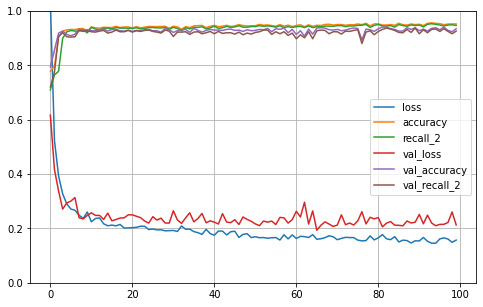

In [89]:
result_m2.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

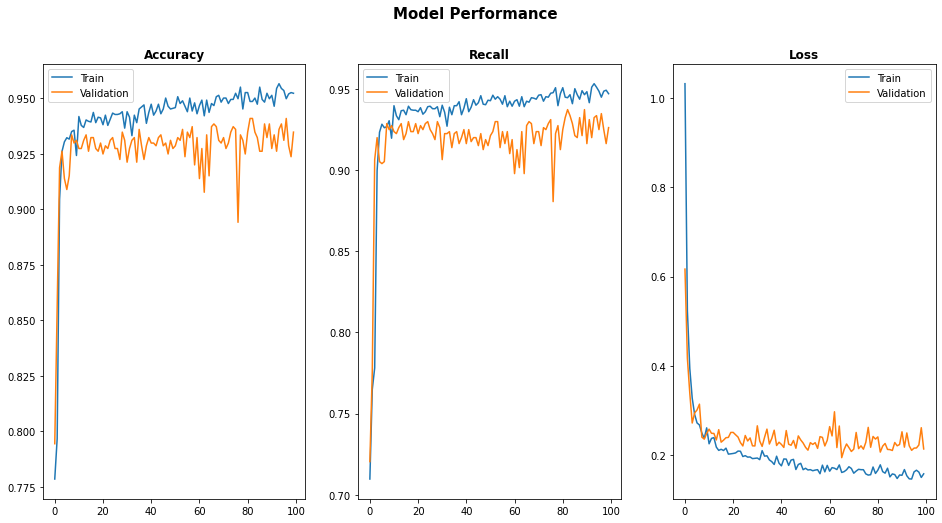

In [91]:
plot_result(result_m2, 'recall_2', 'val_recall_2')

Model still tends to overfit. Validation loss still tends to stagnate compared to the train loss that tends to decrease.

### Evaluate Model_02 to the Test set:

In [92]:
yhat_model_02 = model_02.predict_generator(test_generator)

In [93]:
predicted_classes_m2 = np.argmax(yhat_model_02, axis= 1)
predicted_classes_m2

array([1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [94]:
print(classification_report(test_set_classes, predicted_classes_m2, target_names= test_set_labels))

                   precision    recall  f1-score   support

        with_mask       1.00      1.00      1.00        10
     without_mask       1.00      1.00      1.00         3
wrongly_worn_mask       1.00      1.00      1.00         2

         accuracy                           1.00        15
        macro avg       1.00      1.00      1.00        15
     weighted avg       1.00      1.00      1.00        15



Confusion Matrix, without normalization
[[10  0  0]
 [ 0  3  0]
 [ 0  0  2]]


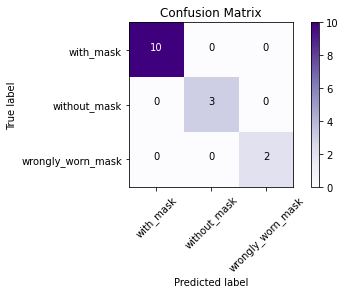

In [95]:
cm_m2 = confusion_matrix(test_set_classes, predicted_classes_m2)
plot_confusion_matrix(cm_m2, test_set_labels, title= 'Confusion Matrix')

Model_02 gives better prediction accuracy to the Test set compared to Model_01. Model can give the predictions of 'with_mask', 'without_mask', 'wrongly_worn_mask' with good accuration and recall scores.

## MODEL INFERENCE

**IMAGE 01**

In [103]:
# Load image 01
image_inf_01 = cv2.imread('../M2/facemask_dataset/inference_images/inference_01.jpg')

In [104]:
# Convert to RGB
image_inf_01_rgb = cv2.cvtColor(image_inf_01, cv2.COLOR_BGR2RGB)

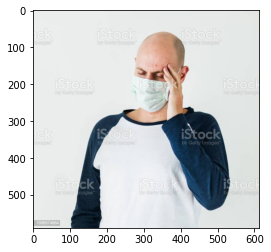

In [105]:
plt.imshow(image_inf_01_rgb)

In [106]:
# Resize image 01 according to the target size
image_inf_01 = cv2.resize(image_inf_01_rgb, image_target_size)

In [107]:
# Normalize image 01
image_inf_01 = image_inf_01 / 255

In [108]:
# Reshape image 01
image_inf_01 = image_inf_01.reshape(1, 34, 30, 3)

In [109]:
# Predict image 01 class
inf_01_pred = np.argmax(model_02.predict(image_inf_01))

In [110]:
class_ind = train_generator.class_indices
class_ind

{'with_mask': 0, 'without_mask': 1, 'wrongly_worn_mask': 2}

In [111]:
y_pred_01=[]
for i,j in class_ind.items():
    if inf_01_pred==j:
        y_pred_01.append(i)

y_pred_01

['with_mask']

**IMAGE 02**

In [112]:
# Load image 02
image_inf_02 = cv2.imread('../M2/facemask_dataset/inference_images/inference_02.jpg')

In [113]:
# Convert to RGB
image_inf_02_rgb = cv2.cvtColor(image_inf_02, cv2.COLOR_BGR2RGB)

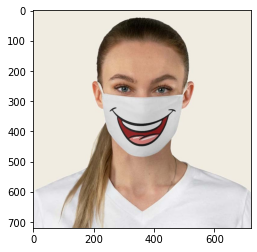

In [114]:
plt.imshow(image_inf_02_rgb)

In [116]:
# Resize image 02 according to the target size
image_inf_02 = cv2.resize(image_inf_02_rgb, image_target_size)

# Normalize image 02
image_inf_02 = image_inf_02 / 255

# Reshape image 02
image_inf_02 = image_inf_02.reshape(1, 34, 30, 3)

In [117]:
# Predict image 02 class
inf_02_pred = np.argmax(model_02.predict(image_inf_02))

y_pred_02=[]
for i,j in class_ind.items():
    if inf_02_pred==j:
        y_pred_02.append(i)

y_pred_02

['with_mask']

**IMAGE 03**

In [118]:
# Load image 03
image_inf_03 = cv2.imread('../M2/facemask_dataset/inference_images/inference_03.jpg')

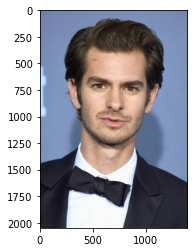

In [119]:
# Convert to RGB
image_inf_03_rgb = cv2.cvtColor(image_inf_03, cv2.COLOR_BGR2RGB)

plt.imshow(image_inf_03_rgb)

In [120]:
# Resize image 03 according to the target size
image_inf_03 = cv2.resize(image_inf_03_rgb, image_target_size)

# Normalize image 03
image_inf_03 = image_inf_03 / 255

# Reshape image 03
image_inf_03 = image_inf_03.reshape(1, 34, 30, 3)

In [121]:
# Predict image 03 class
inf_03_pred = np.argmax(model_02.predict(image_inf_03))

y_pred_03=[]
for i,j in class_ind.items():
    if inf_03_pred==j:
        y_pred_03.append(i)

y_pred_03

['with_mask']

The model gives more accurate prediction on the close-up image of the person's face, as it were trained with the cropped images from their bounding box.

**IMAGE 04**

In [122]:
# Load image 04
image_inf_04 = cv2.imread('../M2/facemask_dataset/inference_images/inference_04.jpg')

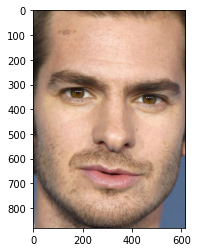

In [123]:
# Convert to RGB
image_inf_04_rgb = cv2.cvtColor(image_inf_04, cv2.COLOR_BGR2RGB)

plt.imshow(image_inf_04_rgb)

In [124]:
# Resize image 04 according to the target size
image_inf_04 = cv2.resize(image_inf_04_rgb, image_target_size)

# Normalize image 04
image_inf_04 = image_inf_04 / 255

# Reshape image 04
image_inf_04 = image_inf_04.reshape(1, 34, 30, 3)

In [125]:
# Predict image 04 class
inf_04_pred = np.argmax(model_02.predict(image_inf_04))

y_pred_04=[]
for i,j in class_ind.items():
    if inf_04_pred==j:
        y_pred_04.append(i)

y_pred_04

['without_mask']

**IMAGE 05**

In [126]:
# Load image 05
image_inf_05 = cv2.imread('../M2/facemask_dataset/inference_images/inference_05.jpg')

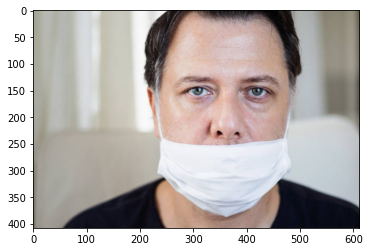

In [127]:
# Convert to RGB
image_inf_05_rgb = cv2.cvtColor(image_inf_05, cv2.COLOR_BGR2RGB)

plt.imshow(image_inf_05_rgb)

In [128]:
# Resize image 05 according to the target size
image_inf_05 = cv2.resize(image_inf_05_rgb, image_target_size)

# Normalize image 05
image_inf_05 = image_inf_05 / 255

# Reshape image 05
image_inf_05 = image_inf_05.reshape(1, 34, 30, 3)

In [129]:
# Prediksi image 05 class
inf_05_pred = np.argmax(model_02.predict(image_inf_05))

y_pred_05=[]
for i,j in class_ind.items():
    if inf_05_pred==j:
        y_pred_05.append(i)

y_pred_05

['with_mask']

**IMAGE 06**

In [130]:
# Load image 06
image_inf_06 = cv2.imread('../M2/facemask_dataset/inference_images/inference_06.jpg')

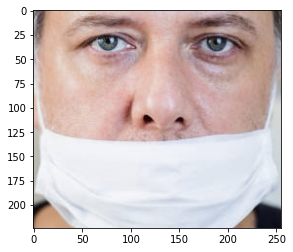

In [131]:
# Convert to RGB
image_inf_06_rgb = cv2.cvtColor(image_inf_06, cv2.COLOR_BGR2RGB)

plt.imshow(image_inf_06_rgb)

In [132]:
# Resize image 06 according to the target size
image_inf_06 = cv2.resize(image_inf_06_rgb, image_target_size)

# Normalize image 06
image_inf_06 = image_inf_06 / 255

# Reshape image 06
image_inf_06 = image_inf_06.reshape(1, 34, 30, 3)

In [133]:
# Predict image 06 class
inf_06_pred = np.argmax(model_02.predict(image_inf_06))

y_pred_06=[]
for i,j in class_ind.items():
    if inf_06_pred==j:
        y_pred_06.append(i)

y_pred_06

['wrongly_worn_mask']

## CONCLUSION

The model performs very well, with a good F1 score, Recall, and Precision towards the 3 classes, but in one specific condition, which the image must be zoomed in at the person's face as the model were trained only with the pictures of the faces.\
It would be better to have balanced labels within the dataset. So it wont tend to give an output of a class instead of the others.